In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time 
from sklearn.metrics import mean_squared_error
# import random
# import seaborn as sns
# import cv2 as cv
# import os
# from glob import glob
# from IPython.display import Image
# from skimage import io, transform
# from PIL import Image
from math import sqrt
import multiprocessing

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
# from torch.autograd import Variable
import torch.nn as nn 
from torch.optim import Adam

import Custom_dataloader as cd   #define utility functions for dataloading and preprocessing
import Custom_model as cm      #define utility functions for building model and loss functions

In [2]:
# #test to see if pytorch can be run on GPU
# torch.cuda.is_available()

Training batch size:  50
Validation batch size:  250
SimpleCNN(
  (cnn_layers): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=1)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): PReLU(num_parameters=1)
    (8): Dropout(p=0.1, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): PReLU(num_parameters=1)
  )
  (linear_layers): Seque

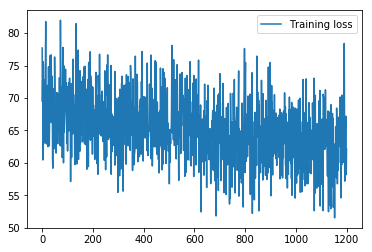

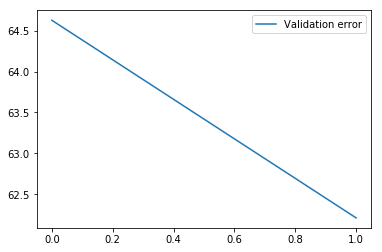

In [5]:
if __name__ == '__main__':
    # define a seed for reproducibility
    seed = 5436457
    torch.manual_seed(seed)
    
    ##Training dataloader
    trainDF = pd.read_csv("./data/piom_train_30k.csv")
    trainDF.drop(columns=["Unnamed: 0"],inplace=True)
    # plt.figure(figsize = (15,8))
    # plt.scatter(trainDF['llcrnrlon'], trainDF['llcrnrlat'], c='blue', marker='.')
    # plt.show()
    train_batch_size = 50
    train_map_data = cd.MapDataset(trainDF, './data/piom_train_png_30k/', transform= transforms.Compose([
                                                cd.SquareRescale(62),
                                                cd.CenterCrop((61,61)),
    #                                                transforms.CenterCrop([124,124]),
    #                                                transforms.ToTensor(),
                                                cd.Normalize(alpha=0., beta=1.),
                                                cd.ToTensor(),
                                            ]))
    train_loader = torch.utils.data.DataLoader(train_map_data,
                                            batch_size=train_batch_size,
                                            shuffle=True,
                                            num_workers=0) #multiprocessing.cpu_count())
    
    ##Validation dataloader
    valDF = pd.read_csv("./data/piom_train2_10k.csv")
    valDF.drop(columns=["Unnamed: 0"],inplace=True)
    val_batch_size = 250
    validation_map_data = cd.MapDataset(valDF, './data/piom_train2_png_10k/', transform= transforms.Compose([
                                                   cd.SquareRescale(62),
                                                   cd.CenterCrop((61,61)),
                                                   cd.Normalize(alpha=0., beta=1.),
                                                   cd.ToTensor(),
                                               ]))
    validation_loader = torch.utils.data.DataLoader(validation_map_data,
                                              batch_size=val_batch_size,
                                              shuffle=True,
                                              num_workers=0, #multiprocessing.cpu_count(),
                                              drop_last=False)
    
#     ##plot a training batch and its localisation
#     for i_batch, sample_batch in enumerate(train_loader):
#         print(i_batch, sample_batch['image'].size())
#         if i_batch == 0:
#             cd.show_batch(sample_batch, trainDF)
#             plt.show()
#             break
    
    #CNN parameters Simple1DCNN
    print('Training batch size: ', train_batch_size)
    print('Validation batch size: ', val_batch_size)
    
    ## defining the model
    model = cm.SimpleCNN()
    ## defining the optimizer
    optimizer = Adam(model.parameters())
    # optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
    # defining the loss function
    # criterion = nn.MSELoss()
    # criterion = Interval_Loss()
    criterion = cm.RMSELoss()
    ## model on GPU if GPU is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # model = model.float()
    model = model.to(device)
    criterion = criterion.to(device)
    print(model)
    
    ## Train the model
    startTrainingTime = time.time()
    n_epochs = 2
    print('number of epochs: ', n_epochs)
    verbose = True
    total_step = len(train_loader)
    loss_list = []
    error_list = []
    compute_validation = True
    val_error_list = []
    for epoch in range(n_epochs):
        for i_batch, sample_batch in enumerate(train_loader):
            # Run the forward pass
            train_X = sample_batch['image'].float().to(device)
            train_Y = sample_batch['coordinates_crnr'].float().to(device)
            outputs = model(train_X)
            loss = criterion(outputs, train_Y)
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
    #         total = train_Y.size(0)
            predicted = outputs.data
    #         print(predicted)
    #         print(train_Y)
            error = sqrt(mean_squared_error(predicted.detach().cpu(),
                                       train_Y.detach().cpu()))
            error_list.append(error)

            if verbose:
                if (i_batch + 1) % 50 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Error: {:.2f}'
                          .format(epoch + 1, n_epochs, i_batch + 1, total_step, loss.item(), error))

        if compute_validation:
            val_predicted = []
            val_true = []
            for i_batch, sample_batch in enumerate(validation_loader):
                # prediction for validation set
                with torch.no_grad():
                    val_X = sample_batch['image'].float().to(device)
                    val_true.extend(sample_batch['coordinates_crnr'].float().detach().cpu())
                    outputs = model(val_X)
                    predicted = outputs.data
                    val_predicted.extend(predicted.detach().cpu())
                if i_batch == 9:
                    break
            val_error = sqrt(mean_squared_error(torch.stack(val_predicted), torch.stack(val_true)))
            val_error_list.append(val_error)
            print('Validation error: {}'.format(val_error)) 

    print("Training time: ", time.time()-startTrainingTime) 
    
    ## plotting the training loss
    plt.plot(loss_list, label='Training loss')
    plt.legend()
    plt.show()
    ## plotting the accuracy error
    plt.plot(val_error_list, label='Validation error')
    plt.legend()
    plt.show()

In [ ]:
# MODEL_PATH = 'gpu_model.pth'
# torch.save(model.state_dict(), MODEL_PATH)

## Result on trainning set

In [35]:
train_predicted = []
train_true = []
total_step = len(train_loader)
for i_batch, sample_batch in enumerate(train_loader):
    # prediction for validation set
    with torch.no_grad():
        train_X = sample_batch['image'].float().to(device)
        train_true.extend(sample_batch['coordinates_center'].float().detach().cpu())
        outputs = model(train_X)
        predicted = outputs.data
        train_predicted.extend(predicted.detach().cpu())
    print('batch {}/{}, error:{}'
          .format(i_batch + 1, total_step, 
                  mean_squared_error(predicted.detach().cpu(), sample_batch['coordinates_center'].float().detach().cpu())))
train_error = mean_squared_error(torch.stack(train_predicted), torch.stack(train_true))
print('Training error: {}'.format(train_error)) 

batch 1/600, error:3302.82763671875
batch 2/600, error:3143.07177734375
batch 3/600, error:2894.73681640625
batch 4/600, error:3056.315673828125
batch 5/600, error:4116.46142578125
batch 6/600, error:1872.1492919921875
batch 7/600, error:2722.81982421875
batch 8/600, error:2918.60791015625
batch 9/600, error:2884.181884765625
batch 10/600, error:2635.937744140625
batch 11/600, error:3848.537109375
batch 12/600, error:3028.88916015625
batch 13/600, error:2483.247802734375
batch 14/600, error:3665.246826171875
batch 15/600, error:3015.699951171875
batch 16/600, error:2117.401123046875
batch 17/600, error:2410.569580078125
batch 18/600, error:2708.4873046875
batch 19/600, error:2476.073974609375
batch 20/600, error:2321.060546875
batch 21/600, error:2126.160400390625
batch 22/600, error:2210.19970703125
batch 23/600, error:2978.956298828125
batch 24/600, error:2797.05029296875
batch 25/600, error:2425.8232421875
batch 26/600, error:1989.58154296875
batch 27/600, error:1633.3519287109375
b

batch 221/600, error:2534.1298828125
batch 222/600, error:3341.092529296875
batch 223/600, error:3298.909912109375
batch 224/600, error:2802.2509765625
batch 225/600, error:3076.2314453125
batch 226/600, error:2690.2255859375
batch 227/600, error:2504.830810546875
batch 228/600, error:3289.108154296875
batch 229/600, error:2291.096923828125
batch 230/600, error:2990.5712890625
batch 231/600, error:2582.529052734375
batch 232/600, error:3121.38427734375
batch 233/600, error:1970.905029296875
batch 234/600, error:2277.9638671875
batch 235/600, error:2617.18310546875
batch 236/600, error:2865.703857421875
batch 237/600, error:3380.166259765625
batch 238/600, error:2833.79931640625
batch 239/600, error:2601.474365234375
batch 240/600, error:3161.277099609375
batch 241/600, error:3590.837890625
batch 242/600, error:2906.2763671875
batch 243/600, error:2581.206298828125
batch 244/600, error:3583.456298828125
batch 245/600, error:2371.502685546875
batch 246/600, error:2765.747314453125
batch 

batch 437/600, error:2245.0830078125
batch 438/600, error:2972.697021484375
batch 439/600, error:2216.126953125
batch 440/600, error:2970.78662109375
batch 441/600, error:3057.37890625
batch 442/600, error:3605.436767578125
batch 443/600, error:2665.01806640625
batch 444/600, error:2152.25439453125
batch 445/600, error:2764.656982421875
batch 446/600, error:2609.33984375
batch 447/600, error:2476.144775390625
batch 448/600, error:2706.609619140625
batch 449/600, error:2673.856689453125
batch 450/600, error:2611.6474609375
batch 451/600, error:1885.525634765625
batch 452/600, error:3442.201416015625
batch 453/600, error:2962.5576171875
batch 454/600, error:2576.821044921875
batch 455/600, error:2675.347900390625
batch 456/600, error:3344.024169921875
batch 457/600, error:3073.86083984375
batch 458/600, error:2821.64208984375
batch 459/600, error:2432.39208984375
batch 460/600, error:2648.0400390625
batch 461/600, error:2905.4326171875
batch 462/600, error:2492.29443359375
batch 463/600,

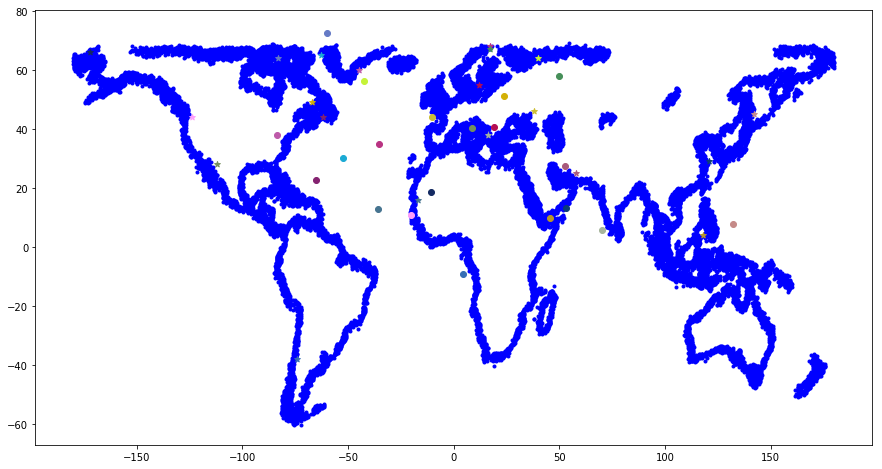

In [36]:
#randomly pick 10 points from the training set and plot prediction vs true position
npoints = 20
plt.figure(figsize = (15,8))
plt.scatter(trainDF['llcrnrlon'], trainDF['llcrnrlat'], c='blue', marker='.')
random_points = random.sample(range(len(train_predicted)), npoints)
for ipoint in random_points:
    color = [np.random.rand(3,)]
    plt.scatter(train_predicted[ipoint][0], train_predicted[ipoint][1], c=color, marker='o')
    plt.scatter(train_true[ipoint][0], train_true[ipoint][1], c=color, marker='*')
plt.savefig('./outputs/training_localisation.png')
plt.show()

## Result on validation set

In [33]:
val_predicted = []
val_true = []
total_step = len(validation_loader)
for i_batch, sample_batch in enumerate(validation_loader):
    # prediction for validation set
    with torch.no_grad():
        val_X = sample_batch['image'].float().to(device)
        val_true.extend(sample_batch['coordinates_center'].float().detach().cpu())
        outputs = model(val_X)
        predicted = outputs.data
        val_predicted.extend(predicted.detach().cpu())
    print('batch {}/{}, error:{}'
          .format(i_batch + 1, total_step, 
                  mean_squared_error(predicted.detach().cpu(), sample_batch['coordinates_center'].float().detach().cpu())))
val_error = mean_squared_error(torch.stack(val_predicted), torch.stack(val_true))
print('Validation error: {}'.format(val_error)) 

batch 1/40, error:2883.65478515625
batch 2/40, error:3136.064208984375
batch 3/40, error:3211.19677734375
batch 4/40, error:3315.4873046875
batch 5/40, error:3488.3271484375
batch 6/40, error:2949.780029296875
batch 7/40, error:3471.22509765625
batch 8/40, error:2917.29443359375
batch 9/40, error:2996.56884765625
batch 10/40, error:3409.320068359375
batch 11/40, error:3518.06591796875
batch 12/40, error:3232.398193359375
batch 13/40, error:3219.3251953125
batch 14/40, error:3550.79052734375
batch 15/40, error:3358.142333984375
batch 16/40, error:3471.014892578125
batch 17/40, error:2859.115234375
batch 18/40, error:3014.693603515625
batch 19/40, error:3097.06494140625
batch 20/40, error:3012.44287109375
batch 21/40, error:2905.70947265625
batch 22/40, error:3183.51806640625
batch 23/40, error:3288.777587890625
batch 24/40, error:3136.82373046875
batch 25/40, error:2991.61865234375
batch 26/40, error:3032.10693359375
batch 27/40, error:3254.79052734375
batch 28/40, error:2882.955078125


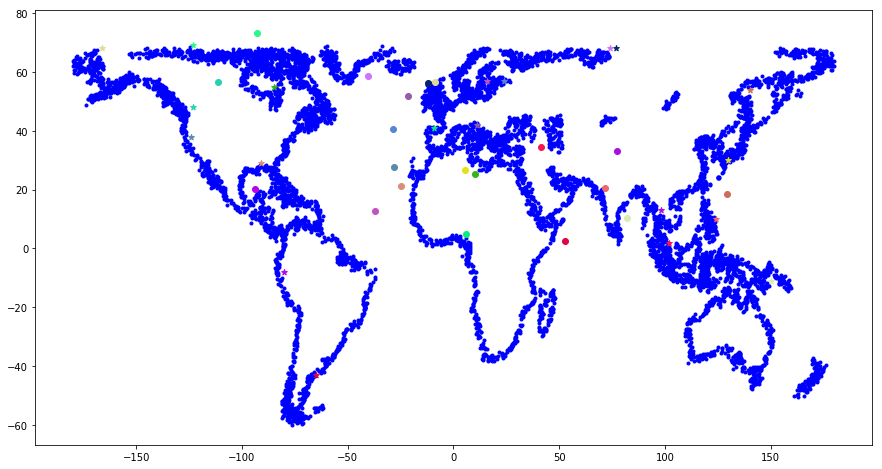

Validation took  0.4357583522796631


In [34]:
#randomly pick 10 points from the validation set and plot prediction vs true position
npoints = 20
plt.figure(figsize = (15,8))
plt.scatter(valDF['llcrnrlon'], valDF['llcrnrlat'], c='blue', marker='.')
random_points = random.sample(range(len(val_predicted)), npoints)
for ipoint in random_points:
    color = [np.random.rand(3,)]
    plt.scatter(val_predicted[ipoint][0], val_predicted[ipoint][1], c=color, marker='o')
    plt.scatter(val_true[ipoint][0], val_true[ipoint][1], c=color, marker='*')
plt.savefig('./outputs/validation_localisation.png')
plt.show()

In [9]:
### define your models here and replace with random generation number 
import time 
startTrainingTime = time.time()
##Write training here
##build and train your model here
##save your model here as h5/pb/pickle or anything binary format to load easily 
## on the inference notebook
##Example of saving model in tensorflow keras:
## tf.keras.models.save_model(
#    model, filepath, overwrite=True, include_optimizer=True, save_format=None,
#    signatures=None, options=None)
## https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model
##Make sure to store your model files (E.g. if you use neural network, save weights)
print("Training took ", time.time()-startTrainingTime)

Training took  5.030632019042969e-05
